In [64]:
from net import Net
import os
import matplotlib.pyplot as plt
from Parser_PINN import get_parser
import scipy.io
import numpy as np
import torch
from torch.autograd import grad
from math import pi

In [65]:
def d(f, x):
    return grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True, only_inputs=True)[0]
#定义微分函数，gradoutputs 向量与f中的自变量有关   create_graph可以计算高阶导数

In [66]:
def PDE(u, t, x, nu):
    return d(u, t) + u * d(u, x) - nu * d(d(u, x), x)
#定义PDE方程u_t + u*u_x -nu*u_xx 应该趋于0，
# 目的是求nu的值，nu的真实值为0.01/pi

In [68]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.cuda('cpu')
    # 加载gpu0

In [69]:
parser = get_parser()

In [70]:
args = parser.parse_args(args=[])
args

Namespace(seq_net=[2, 20, 20, 20, 20, 20, 20, 1], epoch_plot=[200, 1000, 4000], load_path='./Data/burger_2.pth', is_load=False, N_train=10000, epochs=60000, n_f=10000, n_b_1=400, n_b_2=400, n_data=100, PDE_panelty=1.0, BC_panelty=1.0, Data_panelty=1.0, lr=0.001, criterion=MSELoss(), optimizer=<class 'torch.optim.adam.Adam'>, activation=<built-in method tanh of type object at 0x00007FFA4C1EDF30>, activ_name='tanh', t_left=0.0, t_right=1.0, x_left=-1.0, x_right=1.0, save_name='./run/version1')

In [71]:
PINN = Net(seq_net=args.seq_net, activation=args.activation).to(device)
    #建立网络：seq_net=[2, 20, 20, 20, 20, 20, 20, 1]
PINN

Net(
  (features): ModuleDict(
    (MLP_0): Linear(in_features=2, out_features=20, bias=True)
    (MLP_1): Linear(in_features=20, out_features=20, bias=True)
    (MLP_2): Linear(in_features=20, out_features=20, bias=True)
    (MLP_3): Linear(in_features=20, out_features=20, bias=True)
    (MLP_4): Linear(in_features=20, out_features=20, bias=True)
    (MLP_5): Linear(in_features=20, out_features=20, bias=True)
    (MLP_6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [72]:
optimizer = args.optimizer(PINN.parameters(), args.lr)
    #设置优化器，参数为net的参数，学习率为lr=0.001

In [73]:
nu = np.array([0])
#参数初始化：nu==0
nu

array([0])

In [74]:
nu = torch.from_numpy(nu).float().to(device).requires_grad_(True)
#转化nu为张量形式，可以计算梯度
nu

tensor([0.], device='cuda:0', requires_grad=True)

In [75]:
nu.grad = torch.ones((1)).to(device)
nu.grad

tensor([1.], device='cuda:0')

In [76]:
optimizer.add_param_group({'params': nu, 'lr': 0.00001})
#增加一个nu变量，此参数可以影响方程，以至于影响最终loss，我们要得到loss最小时对应的nu，此时为最佳参数
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[-0.4953, -0.5948],
           [ 0.6557,  0.0254],
           [-0.6180, -0.4878],
           [ 0.5577,  0.2669],
           [ 0.1718, -0.3316],
           [-0.4809, -0.1791],
           [-0.5522, -0.3539],
           [ 0.7059, -0.6197],
           [ 0.2108, -0.2105],
           [-0.5089, -0.2915],
           [ 0.3484, -0.1436],
           [-0.5752, -0.4242],
           [-0.4792, -0.1964],
           [-0.3100, -0.3408],
           [ 0.4666, -0.0463],
           [-0.5859, -0.2312],
           [-0.4138,  0.3652],
           [-0.2034,  0.6122],
           [ 0.2701, -0.6366],
           [ 0.1667, -0.4682]], device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([[ 0.0389, -0.0062, -0.0322,  0.1920, -0.0644,  0.1403,  0.2060, -0.1015,
            -0.1487, -0.0597,  0

In [85]:
data = scipy.io.loadmat('Data/burgers_shock.mat')
q=np.shape(data['x'])
q

(256, 1)

In [86]:
Exact = np.real(data['usol']).T

In [87]:
t = data['t'].flatten()[:, None] #展开成1维度，flatten展0维，[:,none]加一维
x = data['x'].flatten()[:, None]
x

array([[-1.        ],
       [-0.99215686],
       [-0.98431373],
       [-0.97647059],
       [-0.96862745],
       [-0.96078431],
       [-0.95294118],
       [-0.94509804],
       [-0.9372549 ],
       [-0.92941176],
       [-0.92156863],
       [-0.91372549],
       [-0.90588235],
       [-0.89803922],
       [-0.89019608],
       [-0.88235294],
       [-0.8745098 ],
       [-0.86666667],
       [-0.85882353],
       [-0.85098039],
       [-0.84313725],
       [-0.83529412],
       [-0.82745098],
       [-0.81960784],
       [-0.81176471],
       [-0.80392157],
       [-0.79607843],
       [-0.78823529],
       [-0.78039216],
       [-0.77254902],
       [-0.76470588],
       [-0.75686275],
       [-0.74901961],
       [-0.74117647],
       [-0.73333333],
       [-0.7254902 ],
       [-0.71764706],
       [-0.70980392],
       [-0.70196078],
       [-0.69411765],
       [-0.68627451],
       [-0.67843137],
       [-0.67058824],
       [-0.6627451 ],
       [-0.65490196],
       [-0

In [88]:
X, T = np.meshgrid(x, t)  #生成二维网格

In [90]:
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # 在水平方向上平铺(25600, 2)
X_star

array([[-1.        ,  0.        ],
       [-0.99215686,  0.        ],
       [-0.98431373,  0.        ],
       ...,
       [ 0.98431373,  0.99      ],
       [ 0.99215686,  0.99      ],
       [ 1.        ,  0.99      ]])

In [92]:
X_star = X_star.astype(np.float32)  # 第一列为x,第二列为t   #数据转换为np
X_star

array([[-1.        ,  0.        ],
       [-0.99215686,  0.        ],
       [-0.9843137 ,  0.        ],
       ...,
       [ 0.9843137 ,  0.99      ],
       [ 0.99215686,  0.99      ],
       [ 1.        ,  0.99      ]], dtype=float32)

In [93]:
X_star = torch.from_numpy(X_star).cuda().requires_grad_(True)   #换成tensor张量 Gpu计算，可求导

In [101]:
u_star = Exact.flatten()[:, None]   #精确解
u_star = u_star.astype(np.float32)
u_star = torch.from_numpy(u_star).cuda().requires_grad_(True)


In [103]:
# data
N_train = 10000  #训练点的数量为10000
N, T = 256, 100
idx = np.random.choice(N * T, N_train, replace=False)
x_train = X_star[idx, 0:1].requires_grad_(True)
t_train = X_star[idx, 1:2].requires_grad_(True)
u_train = u_star[idx]

In [104]:
loss_history = []
# 损失函数历史
Lambda = []
#nu的历史数值
Loss_history = []

test_loss = []


In [105]:
epoch=1

In [106]:
optimizer.zero_grad()
        #把loss关于weight归0

In [107]:
t_f = ((args.t_left + args.t_right) / 2 + (args.t_right - args.t_left) *
               (torch.rand(size=(args.n_f, 1), dtype=torch.float, device=device) - 0.5)
               ).requires_grad_(True)
        # 随机点t属于[0,1] 均匀分布 用args.n_f=10000个点  属于pde内部随机选点

In [108]:
x_f = ((args.x_left + args.x_right) / 2 + (args.x_right - args.x_left) *
               (torch.rand(size=(args.n_f, 1), dtype=torch.float, device=device) - 0.5)
               ).requires_grad_(True)
        ##随机点x属于[-1,1] 均匀分布 用args.n_f=10000个点 属于pde内部随机选点

In [111]:
u_f = PINN(torch.cat([t_f, x_f], dim=1))
        # 内部点pinn得到的函数值
u_f

tensor([[0.0141],
        [0.0091],
        [0.0107],
        ...,
        [0.0013],
        [0.0125],
        [0.0159]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [115]:
PDE_ = PDE(u_f, t_f, x_f, nu)
        # 之前写的pde函数|
PDE_

tensor([[0.0202],
        [0.0198],
        [0.0203],
        ...,
        [0.0231],
        [0.0196],
        [0.0189]], device='cuda:0', grad_fn=<SubBackward0>)

In [116]:
mse_PDE = args.criterion(PDE_, torch.zeros_like(PDE_))
        # 求PDE算出来的损失函数，PDE_要尽可能趋近与0，及内部的点要符合PDE方程，均方误差
mse_PDE

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)

In [122]:
x_rand = ((args.x_left + args.x_right) / 2 + (args.x_right - args.x_left) *
                  (torch.rand(size=(args.n_b_1, 1), dtype=torch.float, device=device) - 0.5)
                  ).requires_grad_(True)
             # 随机点x属于[-1,1] 均匀分布 用n_b_1=400个点 属于pde边界点t=0\
t_b = (args.t_left * torch.ones_like(x_rand)
               ).requires_grad_(True)
             # t_b维度上对齐x_rand，属于边界点t=0
u_b_1 = PINN(torch.cat([t_b, x_rand], dim=1)) + torch.sin(pi * x_rand)
            # t=0,x=[-1,1]上边界点的函数值，要接近-sin(x*pi),现在要趋近于0
u_b_1

tensor([[ 0.9947],
        [ 0.8779],
        [-0.9984],
        [ 0.7760],
        [-0.9215],
        [ 0.4709],
        [-0.0491],
        [-0.8442],
        [ 0.9729],
        [ 0.5225],
        [ 0.2843],
        [-0.3250],
        [ 0.0081],
        [-0.9979],
        [ 0.7474],
        [-0.6975],
        [-0.9990],
        [ 0.9445],
        [ 0.1558],
        [-0.9823],
        [-0.5820],
        [ 0.6649],
        [ 0.1412],
        [-0.0630],
        [-0.1132],
        [ 0.5238],
        [-0.8372],
        [-0.1331],
        [ 0.8400],
        [ 0.4325],
        [ 0.7415],
        [-0.9550],
        [ 0.5850],
        [ 0.9138],
        [ 0.9047],
        [ 0.9879],
        [ 0.4269],
        [ 0.9170],
        [-0.9991],
        [-0.6197],
        [ 0.1214],
        [-0.7702],
        [ 0.4017],
        [-0.2230],
        [-0.2666],
        [ 0.5688],
        [-0.2880],
        [-0.7137],
        [ 0.3672],
        [ 0.9890],
        [-0.0273],
        [-0.9966],
        [-0.

In [128]:
t_rand = ((args.t_left + args.t_right) / 2 + (args.t_right - args.t_left) *
                  (torch.rand(size=(args.n_b_2, 1), dtype=torch.float, device=device) - 0.5)
                  ).requires_grad_(True)
            # 随机点t属于[0,1] 均匀分布 用n_b_2=400个点  属于pde边界随机选点
x_b_1 = (args.x_left * torch.ones_like(t_rand)
                 ).requires_grad_(True)
x_b_2 = (args.x_right * torch.ones_like(t_rand)
                 ).requires_grad_(True)
            # 两个边界条件x=-1与x=1
u_b_2 = PINN(torch.cat([t_rand, x_b_1], dim=1))
        # 左边界的函数值，应该趋近于0
u_b_3 = PINN(torch.cat([t_rand, x_b_2], dim=1))
        # 右边界的函数值，应该趋近与0

In [129]:
mse_BC_1 = args.criterion(u_b_1, torch.zeros_like(u_b_1))
mse_BC_2 = args.criterion(u_b_2, torch.zeros_like(u_b_2))
mse_BC_3 = args.criterion(u_b_3, torch.zeros_like(u_b_3))
# 边界条件的损失函数

In [130]:
mse_BC = mse_BC_1 + mse_BC_2 + mse_BC_3
mse_BC

tensor(0.4986, device='cuda:0', grad_fn=<AddBackward0>)

In [132]:
# Data，精确解损失函数
u_data = PINN(torch.cat([t_train, x_train], dim=1))
mse_Data = args.criterion(u_data, u_train)
#精确解u_train与预测解u_data之间的均方误差

In [134]:
# loss函数综合方程内部与边界条件与精确解条件，权重比例为1：1：1
loss = args.PDE_panelty * mse_PDE + args.BC_panelty * mse_BC + args.Data_panelty*mse_Data
loss

tensor(0.8772, device='cuda:0', grad_fn=<AddBackward0>)

In [135]:
 # Pred loss 预测解与真实解的差距
    
x_pred = X_star[:, 0:1]
t_pred = X_star[:, 1:2]
u_pred = PINN(torch.cat([t_pred, x_pred], dim=1))
mse_test = args.criterion(u_pred, u_star)

In [136]:
#记录损失函数历史
loss_history.append([mse_PDE.item(), mse_BC.item(), mse_Data.item(), mse_test.item()])
#包括pde,bc,data,test所有的损失函数
Lambda.append([nu.item()])
#nu 历史值
Loss_history.append([loss.item()])
#loss 历史值
test_loss.append([mse_test.item()])
#test历史值
loss_history

[[0.00039947673212736845,
  0.49863919615745544,
  0.3781895041465759,
  0.376930832862854]]

In [137]:
loss.backward(retain_graph=True)
        # 反向传播求梯度

In [138]:
optimizer.step()
        # 更新所有参数

In [139]:
print(
    'epoch:{:05d}, PDE: {:.08e}, BC: {:.08e},  loss: {:.08e}'.format(
        epoch+1, mse_PDE.item(), mse_BC.item(), loss.item()
    )
)
print(nu.item())

epoch:00002, PDE: 3.99476732e-04, BC: 4.98639196e-01,  loss: 8.77228141e-01
-9.993357707571704e-06


tensor([[ 0.0007,  0.0007,  0.0007,  ..., -0.0105, -0.0105, -0.0105],
        [ 0.0007,  0.0007,  0.0007,  ..., -0.0104, -0.0105, -0.0105],
        [ 0.0007,  0.0007,  0.0007,  ..., -0.0104, -0.0104, -0.0104],
        ...,
        [ 0.0201,  0.0201,  0.0201,  ...,  0.0091,  0.0091,  0.0091],
        [ 0.0201,  0.0201,  0.0201,  ...,  0.0092,  0.0091,  0.0091],
        [ 0.0202,  0.0201,  0.0201,  ...,  0.0092,  0.0092,  0.0091]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)


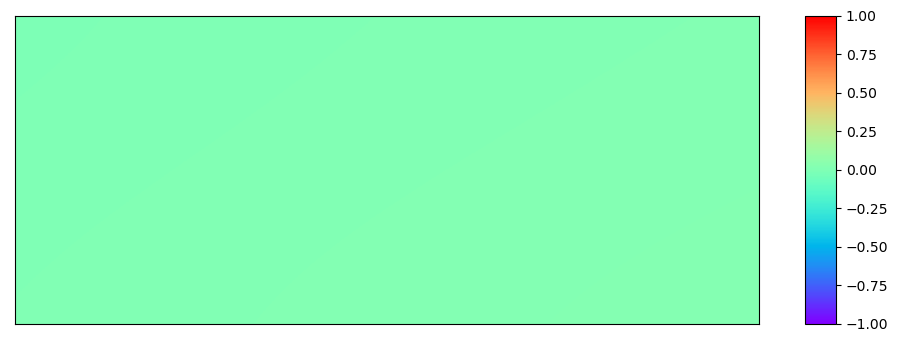

In [146]:

fig = plt.figure(figsize=(12, 4))
xx = torch.linspace(0, 1, 1000).cpu()
yy = torch.linspace(-1, 1, 1000).cpu()
x1, y1 = torch.meshgrid([xx, yy])
#划分网格
s1 = x1.shape
x1 = x1.reshape((-1, 1))
y1 = y1.reshape((-1, 1))
#换成一列数据
out = torch.cat([x1, y1], dim=1).to(device)
z = PINN(out)
z_out = z.reshape(s1)
print(z_out)
out = z_out.cpu().T.detach().numpy()
plt.pcolormesh(xx, yy, out, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-1, 1)  #用来控制颜色缩放的
plt.xticks([])
plt.yticks([])
plt.savefig('./result_plot/PINN_pred({}).png'.format(args.epochs))
plt.show()

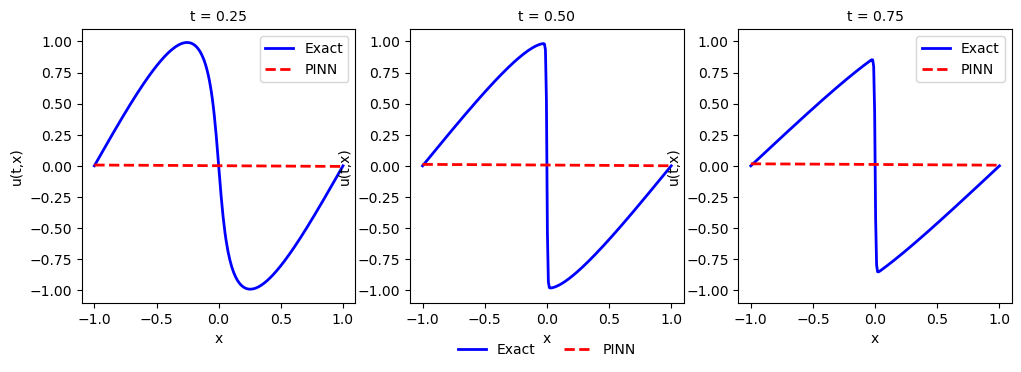

In [149]:
#三幅子图，分别是t=0.25,t=0.5,t=0.75时的x图
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
x_25 = x.astype(np.float32)
x_25 = torch.from_numpy(x_25).cuda().requires_grad_(True)
t_25 = (0.25 * torch.ones_like(x_25)).requires_grad_(True)
u_25 = PINN(torch.cat([t_25, x_25], dim=1))
ax[0].plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
ax[0].plot(x, u_25.reshape((-1, 1)).detach().cpu().numpy(), 'r--', linewidth=2, label='PINN')
ax[0].legend(labels=['Exact','PINN'])
ax[0].set_xlabel('x')
ax[0].set_ylabel('u(t,x)')
ax[0].axis('square')
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title('t = 0.25', fontsize=10)
# ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

t_50 = (0.5 * torch.ones_like(x_25)).requires_grad_(True)
u_50 = PINN(torch.cat([t_50, x_25], dim=1))
ax[1].plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax[1].plot(x, u_50.reshape((-1, 1)).detach().cpu().numpy(), 'r--', linewidth=2, label='PINN')
ax[1].legend(labels=['Exact', 'PINN'])
ax[1].set_xlabel('x')
ax[1].set_ylabel('u(t,x)')
ax[1].axis('square')
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title('t = 0.50', fontsize=10)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, frameon=False)

t_75 = (0.75 * torch.ones_like(x_25)).requires_grad_(True)
u_75 = PINN(torch.cat([t_75, x_25], dim=1))
ax[2].plot(x, Exact[75, :], 'b-', linewidth=2)
ax[2].plot(x, u_75.reshape((-1, 1)).detach().cpu().numpy(), 'r--', linewidth=2)
ax[2].legend(labels=['Exact', 'PINN'])
ax[2].set_xlabel('x')
ax[2].set_ylabel('u(t,x)')
ax[2].axis('square')
ax[2].set_xlim([-1.1, 1.1])
ax[2].set_ylim([-1.1, 1.1])
ax[2].set_title('t = 0.75', fontsize=10)

# plt.savefig('./result_plot/PINN({}).png'.format(args.epochs))
plt.show()

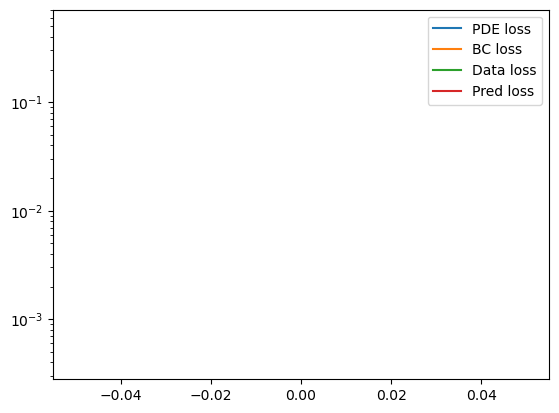

In [150]:
plt.cla()
plt.plot(loss_history)
plt.yscale('log')
# plt.ylim(1e-4, 1e-1)
plt.legend(('PDE loss', 'BC loss', 'Data loss', 'Pred loss'), loc='best')
# plt.savefig('./result_plot/loss({}).png'.format(args.epochs))
plt.show()

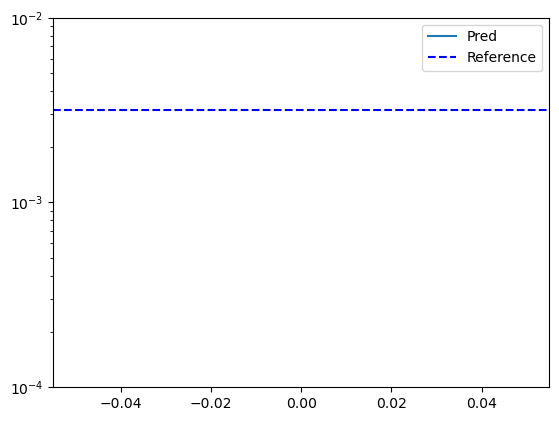

In [151]:
#nu的值
plt.plot(Lambda, label='Pred')
plt.axhline(y=0.01 / pi, color='b', linestyle='--', label='Reference')
plt.yscale('log')
plt.ylim(1e-4, 1e-2)
plt.legend(loc='best')
# plt.savefig('./result_plot/nu_loss({}).png'.format( args.epochs))
plt.show()